# Access Saved Data

Data Broker solves two problems:

* Search for data based on time, a unique identifer, or some other query.
* Load data into standard scientific Python data structures without worrying about file formats.

We have used Bluesky to acquire several Runs and made them available in this example Catalog.

In [1]:
from bluesky_tutorial_utils import get_example_catalog

catalog = get_example_catalog()

/home/travis/virtualenv/python3.7.1/lib/python3.7/site-packages/traitlets/traitlets.py:3036: FutureWarning: --rc={'figure.dpi': 96} for dict-traits is deprecated in traitlets 5.0. You can pass --rc <key=value> ... multiple times to add items to a dict.
  FutureWarning,
/home/travis/virtualenv/python3.7.1/lib/python3.7/site-packages/pims/image_reader.py:26: RuntimeWarning: PIMS image_reader.py could not find scikit-image. Falling back to matplotlib's imread(), which uses floats instead of integers. This may break your scripts. 
(To ignore this warning, include the line "warnings.simplefilter("ignore", RuntimeWarning)" in your script.)
  warnings.warn(RuntimeWarning(ski_preferred))


## What can you do with a Bluesky Catalog?

A Catalog has a length.

In [2]:
len(catalog)

17

Iterating over a Catalog gives the names of its entries.

In [3]:
for name in catalog:
    ...

As with `dict` objects in Python, iterating over a Catalog's `items()` gives ``(name, entry)`` pairs.

In [4]:
for name, entry in catalog.items():
    ...

The Catalogs support lookup by recency, `scan_id`, and globally unique ID.
```python
catalog[-1]  # the most recent Run
catalog[-5]  # the fifth-most-recent Run
catalog[3]  # 'scan_id' == 3 (if ambiguous, returns the most recent match)
catalog["6f3ee9a1-ff4b-47ba-a439-9027cd9e6ced"]  # a full globally unique ID...
catalog["6f3ee9"]  # ...or just enough characters to uniquely identify it (6-8 usually suffices)
```

The globally unique ID is best for use in scripts, but the others are nice for interactive use. All of these incantations return a `BlueskyRun`.

In [5]:
run = catalog[-1]
run

BlueskyRun
  uid='6f3ee9a1-ff4b-47ba-a439-9027cd9e6ced'
  exit_status='success'
  2020-02-03 00:00:00.000 -- 2020-02-03 00:00:00.070
  Streams:
    * baseline
    * primary


Catalog also support search.

In [6]:
results = catalog.search({"plan_name": "count"})
len(results)

10

When you search on a Catalog, you get another Catalog with a subset of the entries. You can search on this in turn, progressively narrowing the results.

In [7]:
from databroker.queries import TimeRange

jan_results = results.search(TimeRange(since="2020-01-01", until="2020-02-01", timezone="US/Eastern"))
len(jan_results)

3

The syntax for these queries is that of [MongoDB](https://docs.mongodb.com/v3.2/reference/operator/query/#query-selectors). It is powerful and flexible, but it takes some getting used to, so databroker is growing higher-level utilities like `TimeRange` to compose common queries in a user-friendly way. We can peek inside if we like to see the MongoDB query that it generates.

In [8]:
dict(TimeRange(since="2020-01-01", until="2020-02-01", timezone="US/Eastern"))

{'time': {'$gte': 1577854800.0, '$lt': 1580533200.0}}

### Exercise

Build some ``TimeRange`` queries, filling in `...` below. Notice that you can specify the time with more or less specificity: try just giving YYYY or YYYY-MM or adding a time. Notice that all of the parameters are optional.

In [9]:
# catalog.search(TimeRange(...))

In [10]:
# catalog.search(TimeRange(...))

In [11]:
# catalog.search(TimeRange(...))

In [12]:
# catalog.search(TimeRange(...))

## What can you with a BlueskyRun?

A `BlueskyRun` bundles together some metadata and several logical tables ("streams") of data. First, the metadata. It always comes in two sections, `"start"` and `"stop"`.

In [13]:
run.metadata["start"]  # Everything we know before the measurements start.

Start({'detectors': ['ns'],
 'hints': {'dimensions': [[['ns_gap'], 'primary']]},
 'motors': ['ns_gap'],
 'num_intervals': 24,
 'num_points': 25,
 'operator': 'Dmitri',
 'plan_args': {'args': ["Signal(name='ns_gap', parent='ns', value=4.0, "
                        'timestamp=1589570582.2353418)',
                        0,
                        4],
               'detectors': ["NewtonSimulator(prefix='', name='ns', "
                             "read_attrs=['gap', 'image'], "
                             'configuration_attrs=[])'],
               'num': 25,
               'per_step': 'None'},
 'plan_name': 'scan',
 'plan_pattern': 'inner_product',
 'plan_pattern_args': {'args': ["Signal(name='ns_gap', parent='ns', value=4.0, "
                                'timestamp=1589570582.2353418)',
                                0,
                                4],
                       'num': 25},
 'plan_pattern_module': 'bluesky.plan_patterns',
 'plan_type': 'generator',
 'scan_id': 1

The above contains a mixture of things that bluesky automatically recorded (e.g. the time), things the bluesky plan reported (e.g. which motor(s) are scanned), and things the user told us (e.g. the name of the operator).

In [14]:
run.metadata["stop"]  # Everything we only know after the measurements stop.

Stop({'exit_status': 'success',
 'num_events': {'baseline': 2, 'primary': 25},
 'reason': '',
 'run_start': '6f3ee9a1-ff4b-47ba-a439-9027cd9e6ced',
 'time': 1580688000.0707304,
 'uid': '44c278f1-f318-44c4-8817-6ef77846b03e'})

These objects `Start` and `Stop` are just dictionaries. You can dig into their contents in the usual way.

In [15]:
run.metadata["start"]["num_points"]

25

In [16]:
run.metadata["stop"]["exit_status"] == "success"

True

As we said, a Run bundles together any number of "streams" of data. Picture these as tables or spreadsheets. The stream names are shown when we print `run`.

In [17]:
run

BlueskyRun
  uid='6f3ee9a1-ff4b-47ba-a439-9027cd9e6ced'
  exit_status='success'
  2020-02-03 00:00:00.000 -- 2020-02-03 00:00:00.070
  Streams:
    * baseline
    * primary


We can also list them programmatically.

In [18]:
list(run)

['baseline', 'primary']

We can access a particular stream like `run["primary"].read()`. Dot access also works — `run.primary.read()` — if the stream name is a valid Python identifier and does not collide with any other attributes.

In [19]:
ds = run["primary"].read()
ds

<xarray.Dataset>
Dimensions:   (time: 25, x: 128, y: 128)
Coordinates:
  * time      (time) float64 1.581e+09 1.581e+09 ... 1.581e+09 1.581e+09
Dimensions without coordinates: x, y
Data variables:
    ns_gap    (time) float64 0.0 0.1667 0.3333 0.5 ... 3.5 3.667 3.833 4.0
    ns_image  (time, x, y) float64 1.258 1.959 1.752 ... 1.752 1.959 1.258

This is an `xarray.Dataset`. At this point Bluesky and Data Broker have served their purpose and handed us a useful, general-purpose scientific Python data structure with our data in it.

## What can you do with an `xarray.Dataset`?

We can easily generate scatter plots of one dimension vs another.

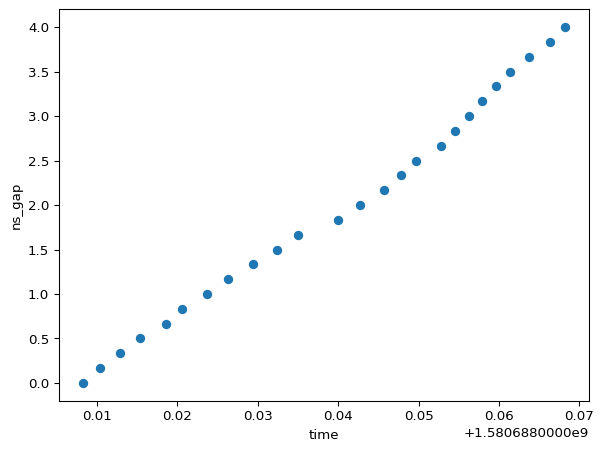

In [20]:
ds.plot.scatter(x="time", y="ns_gap")

We can pull out specific columns. (Each column in an `xarray.Dataset` is called an `xarray.DataArray`.)

In [21]:
image = ds["ns_image"]
image

<xarray.DataArray 'ns_image' (time: 25, x: 128, y: 128)>
array([[[1.25826974, 1.95925757, 1.75195039, ..., 1.75195039,
         1.95925757, 1.25826974],
        [1.95925757, 1.74115687, 0.83008752, ..., 0.83008752,
         1.74115687, 1.95925757],
        [1.75195039, 0.83008752, 0.07707731, ..., 0.07707731,
         0.83008752, 1.75195039],
        ...,
        [1.75195039, 0.83008752, 0.07707731, ..., 0.07707731,
         0.83008752, 1.75195039],
        [1.95925757, 1.74115687, 0.83008752, ..., 0.83008752,
         1.74115687, 1.95925757],
        [1.25826974, 1.95925757, 1.75195039, ..., 1.75195039,
         1.95925757, 1.25826974]],

       [[0.29249125, 1.23494802, 1.9468762 , ..., 1.9468762 ,
         1.23494802, 0.29249125],
        [1.23494802, 1.9519689 , 1.76847642, ..., 1.76847642,
         1.9519689 , 1.23494802],
        [1.9468762 , 1.76847642, 0.87194573, ..., 0.87194573,
         1.76847642, 1.9468762 ],
...
        [0.80507418, 0.0616111 , 0.20513158, ..., 0.20513158,
         0.0616111 , 0.80507418],
        [1.72430956, 0.78918797, 0.0616111 , ..., 0.0616111 ,
         0.78918797, 1.72430956],
        [1.9657785 , 1.72430956, 0.80507418, ..., 0.80507418,
         1.72430956, 1.9657785 ]],

       [[1.25826974, 1.95925757, 1.75195039, ..., 1.75195039,
         1.95925757, 1.25826974],
        [1.95925757, 1.74115687, 0.83008752, ..., 0.83008752,
         1.74115687, 1.95925757],
        [1.75195039, 0.83008752, 0.07707731, ..., 0.07707731,
         0.83008752, 1.75195039],
        ...,
        [1.75195039, 0.83008752, 0.07707731, ..., 0.07707731,
         0.83008752, 1.75195039],
        [1.95925757, 1.74115687, 0.83008752, ..., 0.83008752,
         1.74115687, 1.95925757],
        [1.25826974, 1.95925757, 1.75195039, ..., 1.75195039,
         1.95925757, 1.25826974]]])
Coordinates:
  * time     (time) float64 1.581e+09 1.581e+09 ... 1.581e+09 1.581e+09
Dimensions without coordinates: x, y
Attributes:
    object:   ns

Inside this `xarray.DataArray` is a plain old numpy array.

In [22]:
type(image.values)

numpy.ndarray

The extra context provided by xarray is very useful. Notice that the dimensions have names, so we can perform aggregations over named axes without remembering the _order_ of the dimensions.

In [23]:
image.sum("time")  # With just plain numpy, this would be image.sum(0) and we'd have to keep track ourselves that 0 = "time".

<xarray.DataArray 'ns_image' (x: 128, y: 128)>
array([[25.25826974, 25.95925757, 25.75195039, ..., 25.75195039,
        25.95925757, 25.25826974],
       [25.95925757, 25.74115687, 24.83008752, ..., 24.83008752,
        25.74115687, 25.95925757],
       [25.75195039, 24.83008752, 24.07707731, ..., 24.07707731,
        24.83008752, 25.75195039],
       ...,
       [25.75195039, 24.83008752, 24.07707731, ..., 24.07707731,
        24.83008752, 25.75195039],
       [25.95925757, 25.74115687, 24.83008752, ..., 24.83008752,
        25.74115687, 25.95925757],
       [25.25826974, 25.95925757, 25.75195039, ..., 25.75195039,
        25.95925757, 25.25826974]])
Dimensions without coordinates: x, y

The `plot` method on `xarray.DataArray` often just "does the right thing" based on the dimensionality of the data. It even labels our axes for us!

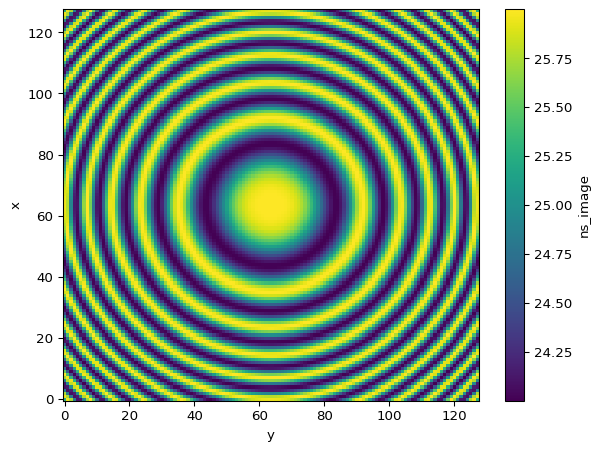

In [24]:
image.sum("time").plot()

For a quick overview of xarray see [the xarray documentation](https://xarray.pydata.org/en/stable/quick-overview.html). Also see these tutorials in particular for interesting usages of xarray:

* [Slice and Interpolate Image Data](./Slice%20and%20Interpolate%20Image%20Data.ipynb)
* [Higher Dimensional Data](./Higher%20Dimensional%20Data.ipynb)

## Exercises

1. Coming back to our `run`

In [25]:
run

BlueskyRun
  uid='6f3ee9a1-ff4b-47ba-a439-9027cd9e6ced'
  exit_status='success'
  2020-02-03 00:00:00.000 -- 2020-02-03 00:00:00.070
  Streams:
    * baseline
    * primary


read the "baseline" stream. The baseline stream conventionally includes readings taken just before and after a scan to record all potentially-relevant positions and temperatures and note if they have drifted.

In [26]:
# Try your solution here.

In [27]:
%load solutions/access_baseline_data.py